In [5]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [6]:
class Cube:
    def __init__(self, size): # 随机初始化位置坐标
        self.size = size
        self.x = np.random.randint(0, self.size-1)
        self.y = np.random.randint(0, self.size-1)
    def __str__(self):
        return f'{self.x},{self.y}'
    def __sub__(self, other):
        return (self.x-other.x,self.y- other.y)
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    def action(self,choise):
        if choise == 0:
            self.move(x=1,y=1)
        elif choise == 1:
            self.move(x=-1, y=1)
        elif choise == 2:
            self.move(x=1, y=-1)
        elif choise == 3:
            self.move(x=-1, y=-1)
        elif choise == 4:
            self.move(x=0, y=1)
        elif choise == 5:
            self.move(x=0, y=-1)
        elif choise == 6:
            self.move(x=1, y=0)
        elif choise == 7:
            self.move(x=-1, y=0)
        elif choise == 8:
            self.move(x=0, y=0)
    def move(self,x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        if self.x< 0:
            self.x = 0
        if self.x> self.size -1:
            self.x = self.size-1
        if self.y< 0:
            self.y = 0
        if self.y> self.size -1:
            self.y = self.size-1

class envCube:
    SIZE = 10
    OBSERVATION_SPACE_VALUES = (SIZE,SIZE,3)
    ACTION_SPACE_VALUES = 9
    RETURN_IMAGE = False     # 考虑返回值是否图像

    FOOD_REWARD = 25  # agent获得食物的奖励
    ENEMY_PENALITY = -300  # 遇上对手的惩罚
    MOVE_PENALITY = -1  # 每移动一步的惩罚

    # 设定三个部分的颜色分别是蓝、绿、红
    d = {1: (255, 0, 0),  # blue
         2: (0, 255, 0),  # green
         3: (0, 0, 255)}  # red
    PLAYER_N = 1
    FOOD_N = 2
    ENEMY_N = 3

    # 环境重置
    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        self.enemy = Cube(self.SIZE)
        # 如果玩家和食物初始位置相同，重置食物的位置，直到位置不同
        while self.player == self.food:
            self.food = Cube(self.SIZE)
        # 如果敌人和玩家或食物的初始位置相同，重置敌人的位置，直到位置不同
        while self.player == self.enemy or self.food == self.enemy:
            self.enemy = Cube(self.SIZE)
        # 判断观测是图像和数字
        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food)+(self.player - self.enemy)

        self.episode_step = 0

        return observation

    def step(self,action):
        self.episode_step +=1
        self.player.action(action)
        self.enemy.move()
        self.food.move()
        # 判断观测是图像和数字
        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food) + (self.player - self.enemy)

        # 奖励
        if self.player.x == self.food.x and self.player.y == self.food.y:
            reward = self.FOOD_REWARD
        elif self.player.x == self.enemy.x and self.player.y == self.enemy.y:
            reward = self.ENEMY_PENALITY
        else:
            reward = self.MOVE_PENALITY

        done = False

        if self.player == self.food or self.player == self.enemy or self.episode_step >=200:
            done = True

        return new_observation,reward,done

    def render(self):
        img = self.get_image()
        img = img.resize((800, 800))
        cv2.imshow('Predator',np.array(img))
        cv2.waitKey(1)

    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]
        img = Image.fromarray(env, 'RGB')
        return img

    def get_qtable(self,q_table_name=None):
        # 初始化Q表格
        if q_table_name is None:  # 如果没有表格提供，就随机初始化一个Q表格
            q_table = {}
            for x1 in range(-self.SIZE + 1, self.SIZE):
                for y1 in range(-self.SIZE + 1, self.SIZE):
                    for x2 in range(-self.SIZE + 1, self.SIZE):
                        for y2 in range(-self.SIZE + 1, self.SIZE):
                            q_table[(x1, y1, x2, y2)] = [np.random.randint(-5, 0) for i in range(self.ACTION_SPACE_VALUES)]
        else:  # 提供了，就使用提供的Q表格
            with open(q_table_name, 'rb') as f:
                q_table = pickle.load(f)
        return q_table


In [7]:
SIZE = 10           # 游戏区域的大小
EPISODES = 30000    # 局数
SHOW_EVERY = 3000   # 定义每隔多少局展示一次图像

FOOD_REWARD = 25      # agent获得食物的奖励
ENEMY_PENALITY = 300  # 遇上对手的惩罚
MOVE_PENALITY = 1     # 每移动一步的惩罚

epsilon = 0.6
EPS_DECAY = 0.9998
DISCOUNT = 0.95
LEARNING_RATE = 0.1

q_table = None
# 设定三个部分的颜色分别是蓝、绿、红
d = {1:(255,0,0), # blue
     2:(0,255,0), # green
     3:(0,0,255)} # red
PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3


episode  0   epsilon: 0.6
mean_reward: nan
episode  3000   epsilon: 0.32926722239570905
mean_reward: -180.70866666666666
episode  6000   epsilon: 0.18069483957364205
mean_reward: -134.30766666666668
episode  9000   epsilon: 0.09916147987941909
mean_reward: -99.36333333333333
episode  12000   epsilon: 0.054417708414240505
mean_reward: -72.981
episode  15000   epsilon: 0.029863279497827713
mean_reward: -60.421
episode  18000   epsilon: 0.016388331819794114
mean_reward: -53.474666666666664
episode  21000   epsilon: 0.00899356749667138
mean_reward: -42.11333333333334
episode  24000   epsilon: 0.00493547831509555
mean_reward: -38.79933333333334
episode  27000   epsilon: 0.0027084853933429503
mean_reward: -39.84166666666667


C:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


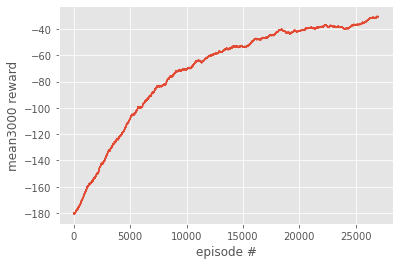

In [8]:
env = envCube()
q_table = env.get_qtable()

# 训练一个智能体
episode_rewards = []                    # 初始化奖励序列
for episode in range (EPISODES):
    obs = env.reset()
    done = False

    # 每隔一段时间设定show为True，显示图像
    if episode % SHOW_EVERY == 0:
        print('episode ',episode,'  epsilon:',epsilon)
        print('mean_reward:',np.mean(episode_rewards[-SHOW_EVERY:]))
        show = True
    else:
        show = False

    episode_reward = 0
    while not done:
        # 开发和探索并存
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])   # 选择Q值最高的动作，来进行开发
        else:
            action = np.random.randint(0, env.ACTION_SPACE_VALUES)    # 随机选择一个动作，进行探索

        new_obs, reward, done = env.step(action)

        # 更新Q表格
        current_q = q_table[obs][action]            # 当前动作、状态对应的Q值
        max_future_q = np.max(q_table[new_obs])     # 新的状态下，最大的Q值
        if reward ==env.FOOD_REWARD:
            new_q = env.FOOD_REWARD
        else:
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT* max_future_q)
        q_table[obs][action] = new_q
        obs = new_obs

        # 图像显示
        if show:
            env.render()

        episode_reward += reward

    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean{SHOW_EVERY} reward')
plt.show()

with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)





















